# Oxford5k VLAD Retrieval Demo

This notebook demonstrates how to:
1. Load the Oxford Flower dataset.
2. Extract deep convolutional features (last conv layer) from a pretrained model.
3. Train a VLAD model on these deep features.
4. Perform image retrieval queries.
5. Compute and plot the Mean Average Precision (mAP).
6. Compare different numbers of clusters for VLAD: 32, 64, 128, 256, 512.
7. Show the effect of PCA (reducing features by half before VLAD) on retrieval performance.




## 1. Imports and Setup

In [1]:
import os
import numpy as np
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from torchvision import transforms
from torchvision.models import vgg16, VGG16_Weights
from tqdm import tqdm

# Our library imports
from src.features._features import DeepConvFeatureExtractor
from src.metrics.vlad import VLAD
from src.datasets import OxfordFlowerDataset  # We'll create this in a moment
from src.config import DEVICE, ROOT
from src.utils import *

print("Device in use:", DEVICE)

Device used: cuda
2025-01-03 19:48:47,190 - numexpr.utils - INFO - Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2025-01-03 19:48:47,191 - numexpr.utils - INFO - NumExpr defaulting to 8 threads.
Device in use: cuda


C:\Users\vunha\anaconda3\envs\conda_env\Lib\site-packages\albumentations\__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.24 (you have 1.4.23). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


### Hyperparameters

**Note**: training k-means models takes quite a bit of time. In this notebook, a single `n_clusters = 256` will be used. Add more values to `NUM_CLUSTERS` to experiment with different cluster sizes.

In [2]:
NUM_CLUSTERS = [256]
IMAGE_SIZE = (224, 224)
PCA_OPTIONS = [True, False]

## 2. Declare the Oxford Flower Dataset

In [3]:
transformer = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Resize(IMAGE_SIZE)
    ]
)

train_dataset = OxfordFlowerDataset(transform=transformer, purpose='train')
print("Number of images in the dataset:", len(train_dataset))

Number of images in the dataset: 6149


### Plot some images

Image size: torch.Size([3, 224, 224])


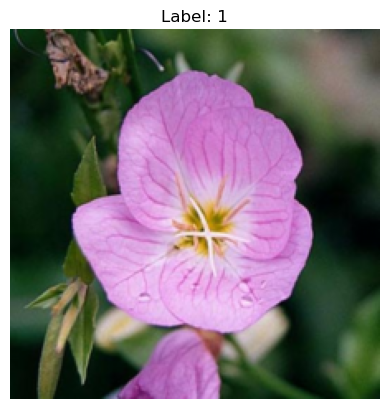

Image size: torch.Size([3, 224, 224])


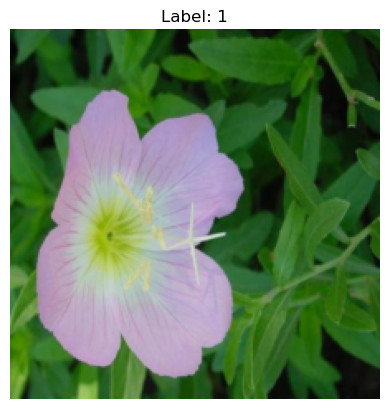

Image size: torch.Size([3, 224, 224])


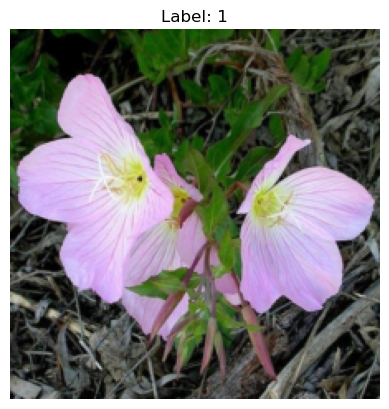

Image size: torch.Size([3, 224, 224])


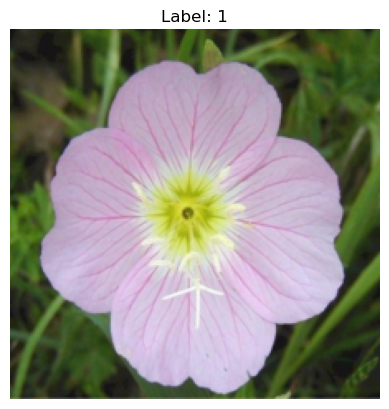

Image size: torch.Size([3, 224, 224])


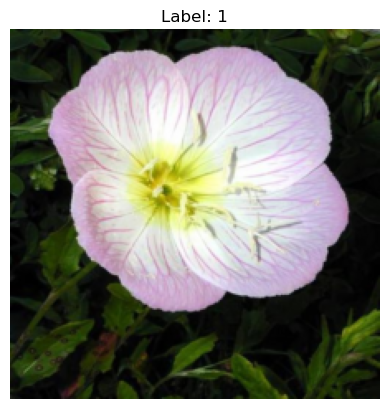

In [4]:
for i in range(5):
    img, label = train_dataset[i]
    print("Image size:", img.shape)
    plot_image(img, title = f"Label: {label}")

### 3. Extract deep convolutional features

We use `DeepConvFeatureExtractor` from our code. For demonstration, we'll pick `vgg16` and the last conv layer.


In [5]:
from tqdm import tqdm

extractor = DeepConvFeatureExtractor(
    model=vgg16(weights=VGG16_Weights.DEFAULT),
    layer_index=-1,  # Last conv layer
    append_spatial_coords=True,
    device=DEVICE
)

2025-01-03 19:48:54,340 - Feature_Extractor - INFO - Device used: cuda
2025-01-03 19:48:54,342 - Feature_Extractor - INFO - Selected layer: features.28, Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


### Extract features


In [6]:
images = []
labels = []
paths = []
features = []

for i in tqdm(range(len(train_dataset))):
    img, label, path = train_dataset[i]
    img = img.to(DEVICE)
    feature = extractor(img)
    images.append(img)
    labels.append(label)
    paths.append(path)
    features.append(feature)

 69%|██████▉   | 4234/6149 [05:45<02:36, 12.27it/s]


KeyboardInterrupt: 

## 4. Training VLAD Model
We'll loop over different `n_clusters` and optionally apply PCA before fitting. The result is saved as an HDF5 file for easier use later.


In [ ]:
for use_pca in PCA_OPTIONS:
    for k in NUM_CLUSTERS:
        # 1) Prepare data for k-means
        #    We might randomly sample local descriptors from the entire set for the dictionary
        #    or flatten them all. Be mindful of memory usage.

        # Flatten all features for k-means training
        all_descriptors = np.vstack(features)  # shape: (total_keypoints, descriptor_dim)

        pca_model = None

        # 2) If using PCA
        if use_pca:
            dim = all_descriptors.shape[1] // 2
            pca_model = PCA(n_components=dim).fit(all_descriptors)
            all_descriptors = pca_model.transform(all_descriptors)
        else:
            pca_model = None

        # 3) Fit KMeans
        kmeans_model = KMeans(n_clusters=k, random_state=42)
        kmeans_model.fit(all_descriptors)

        # 4) Create VLAD metric object
        vlad_metric = VLAD(
            feature_extractor=extractor,
            kmeans_model=kmeans_model,
            power_norm_weight=0.5,
            norm_order=2,
            epsilon=1e-9,
            flatten=True,
            pca=pca_model
        )

        vlad_vectors = np.vstack([vlad_metric.compute_vector(img) for img in images])
        vlad_data = {os.path.basename(path): vlad_vectors[i] for i, image, _, path in enumerate(train_dataset)}
        save_to_hdf5(f'{ROOT}/res/vlad_{k}_clusters_pca_{use_pca}_deep_features_vgg16.h5', vlad_vectors)


## 5. Compute VLAD vectors for train images

the result is saved as hdf5 file for easier use later.